In [19]:
##pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install qiskit_ibm_provider


[notice] A new release of pip available: 23.1.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [22]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit_ibm_providers import least_busy
from qiskit import QuantumCircuit, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

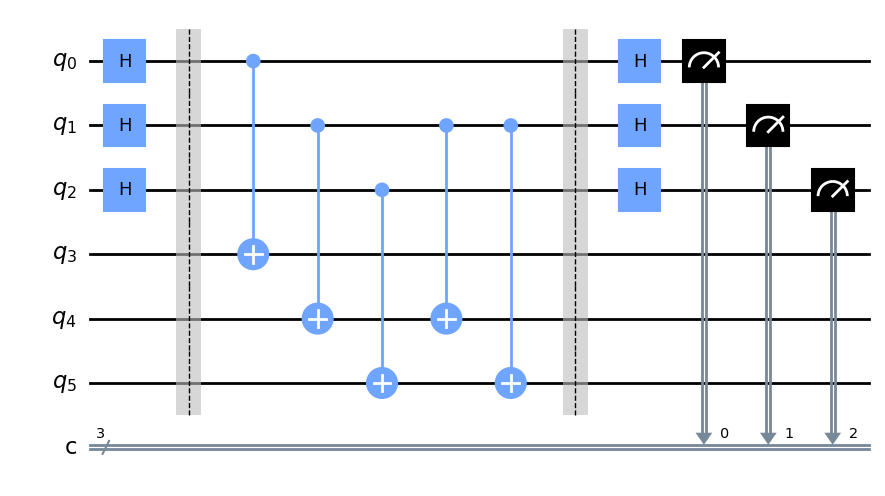

In [8]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit = simon_circuit.compose(simon_oracle(b))

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

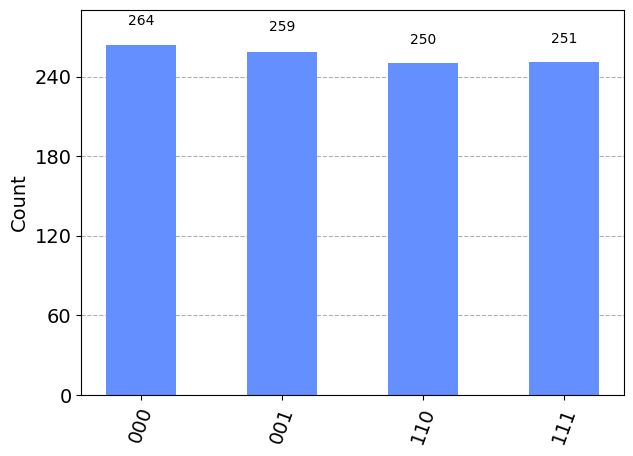

In [12]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(simon_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

In [13]:
print(counts)

{'110': 250, '111': 251, '000': 264, '001': 259}


In [15]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

110.110 = 0 (mod 2)
110.111 = 0 (mod 2)
110.000 = 0 (mod 2)
110.001 = 0 (mod 2)


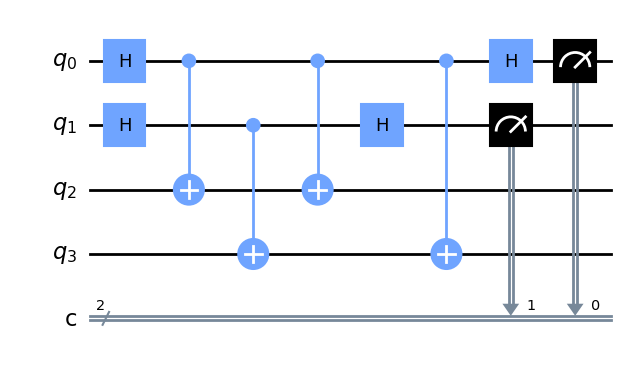

In [16]:
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit_2.h(range(n))

# Query oracle
simon_circuit_2 = simon_circuit_2.compose(simon_oracle(b))

# Apply Hadamard gates to the input register
simon_circuit_2.h(range(n))

# Measure qubits
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw()

In [32]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Execute and monitor the job
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit_2, backend, optimization_level=3)
job = backend.run(transpiled_simon_circuit)
job_monitor(job, interval=2)

ibmqfactory.load_account:WARNING:2023-12-04 15:00:40,339: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_kyoto
Job Status: job has successfully run


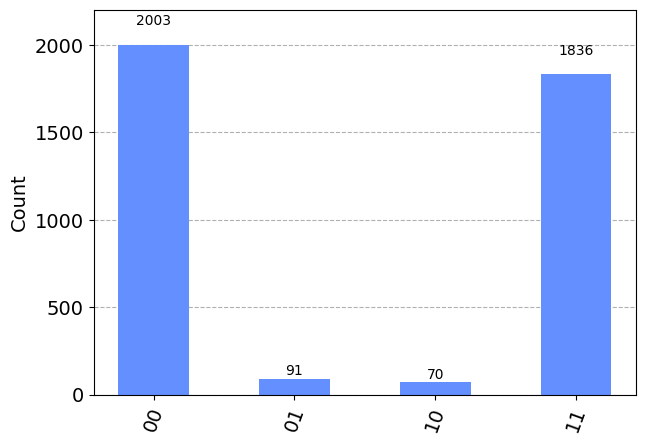

In [33]:
# Get results and plot counts
device_counts = job.result().get_counts()
plot_histogram(device_counts)

In [34]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

print('b = ' + b)
for z in device_counts:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), device_counts[z]*100/shots))

b = 11
11.11 = 0 (mod 2) (179.3%)
11.00 = 0 (mod 2) (195.6%)
11.01 = 1 (mod 2) (8.9%)
11.10 = 1 (mod 2) (6.8%)
